In [ ]:
#Just a quick AI-assisted comparison of the two different sampling approaches for theta (lepton opening angle). Some 
#differences but they're pretty marginal
import numpy as np
import awkward as ak
import uproot as up
import matplotlib.pyplot as plt

# ----------------------------
# USER INPUT: set your files
# ----------------------------
FILE_A = "newton.root"   # e.g. NEWTON
FILE_B = "MuDar.root"   # e.g. Haxton's MuDAR plot

# ----------------------------
# Tree / branch configuration
# ----------------------------
EVENT_TREE = "eventTree"

# Edit these if needed to match your output
BRANCHES = {
    "eventNum": "eventNum",
    "Enu": "Enu",
    "Ex": "Ex",
    "twoJ": "twoJ",
    "parity": "parity",
    "theta_deg": "theta_deg",

    # outgoing particles (jagged per event)
    "out_pdg": "outParticlePDG",
    "out_totalE": "outParticleTotalE",  
    "out_ke": "outParticleKE",          
    "out_mass": "outParticleMass",
    "out_px": "outParticlePx",
    "out_py": "outParticlePy",
    "out_pz": "outParticlePz",
}

# PDG codes
PDG_ELECTRON = 11
PDG_POSITRON = -11


In [30]:
def _available_branches(path, tree_name):
    with up.open(path) as f:
        t = f[tree_name]
        return set(t.keys())

def _resolve_out_energy_branch(avail):
    # Prefer KE if present; otherwise totalE; otherwise None
    if BRANCHES["out_ke"] in avail:
        return "ke"
    if BRANCHES["out_totalE"] in avail:
        return "totalE"
    return None

def load_file(path):
    """Load the eventTree and derive per-event lepton quantities (electron/positron)."""
    avail = _available_branches(path, EVENT_TREE)
    out_energy_mode = _resolve_out_energy_branch(avail)
    if out_energy_mode is None:
        raise KeyError(
            f"Neither '{BRANCHES['out_ke']}' nor '{BRANCHES['out_totalE']}' found in {path}:{EVENT_TREE}.\n"
            f"Available branches include: {sorted(list(avail))[:40]} ..."
        )

    # Minimal set of branches we need
    want = [
        BRANCHES["eventNum"], BRANCHES["Enu"], BRANCHES["Ex"], BRANCHES["twoJ"], BRANCHES["parity"], BRANCHES["theta_deg"],
        BRANCHES["out_pdg"],
        BRANCHES["out_mass"],
        BRANCHES["out_px"], BRANCHES["out_py"], BRANCHES["out_pz"],
    ]
    if out_energy_mode == "ke":
        want.append(BRANCHES["out_ke"])
    else:
        want.append(BRANCHES["out_totalE"])

    with up.open(path) as f:
        arr = f[EVENT_TREE].arrays(want, library="ak")

    out_pdg = arr[BRANCHES["out_pdg"]]

    # Select electrons/positrons among outParticles
    is_lepton = (out_pdg == PDG_ELECTRON) | (out_pdg == PDG_POSITRON)

    # Extract first lepton per event (if multiple, take the first)
    lep_pdg = ak.firsts(out_pdg[is_lepton])

    lep_mass = ak.firsts(arr[BRANCHES["out_mass"]][is_lepton])
    lep_px   = ak.firsts(arr[BRANCHES["out_px"]][is_lepton])
    lep_py   = ak.firsts(arr[BRANCHES["out_py"]][is_lepton])
    lep_pz   = ak.firsts(arr[BRANCHES["out_pz"]][is_lepton])

    if out_energy_mode == "ke":
        lep_ke = ak.firsts(arr[BRANCHES["out_ke"]][is_lepton])
        lep_totalE = lep_ke + lep_mass
    else:
        lep_totalE = ak.firsts(arr[BRANCHES["out_totalE"]][is_lepton])
        lep_ke = lep_totalE - lep_mass

    lep_p = np.sqrt(lep_px**2 + lep_py**2 + lep_pz**2)

    # Some events may have no lepton in outParticles; mask them out for lepton-specific plots
    has_lepton = ~ak.is_none(lep_pdg)

    # Convert to NumPy for plotting
    data = {
        "path": path,
        "eventNum": ak.to_numpy(arr[BRANCHES["eventNum"]]),
        "Enu": ak.to_numpy(arr[BRANCHES["Enu"]]),
        "Ex": ak.to_numpy(arr[BRANCHES["Ex"]]),
        "twoJ": ak.to_numpy(arr[BRANCHES["twoJ"]]),
        "parity": ak.to_numpy(arr[BRANCHES["parity"]]),
        "theta_deg": ak.to_numpy(arr[BRANCHES["theta_deg"]]),

        "has_lepton": ak.to_numpy(has_lepton),
        "lep_pdg": ak.to_numpy(ak.fill_none(lep_pdg, 0)),
        "lep_ke": ak.to_numpy(ak.fill_none(lep_ke, np.nan)),
        "lep_totalE": ak.to_numpy(ak.fill_none(lep_totalE, np.nan)),
        "lep_p": ak.to_numpy(ak.fill_none(lep_p, np.nan)),
        "lep_pz": ak.to_numpy(ak.fill_none(lep_pz, np.nan)),
    }
    return data

dataA = load_file(FILE_A)
dataB = load_file(FILE_B)

print("Loaded:")
print("A:", dataA["path"], "events =", len(dataA["eventNum"]), "lepton events =", int(np.sum(dataA["has_lepton"])))
print("B:", dataB["path"], "events =", len(dataB["eventNum"]), "lepton events =", int(np.sum(dataB["has_lepton"])))


Loaded:
A: newton.root events = 1000000 lepton events = 1000000
B: MuDar.root events = 1000000 lepton events = 1000000


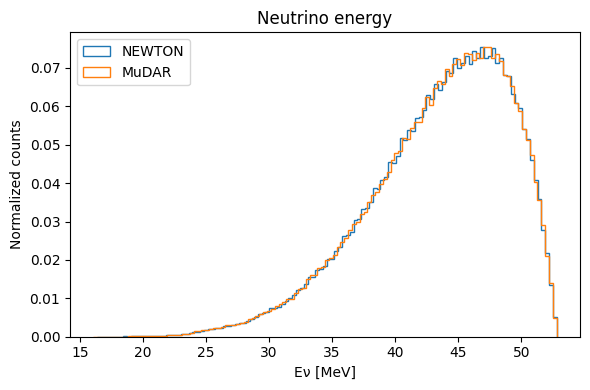

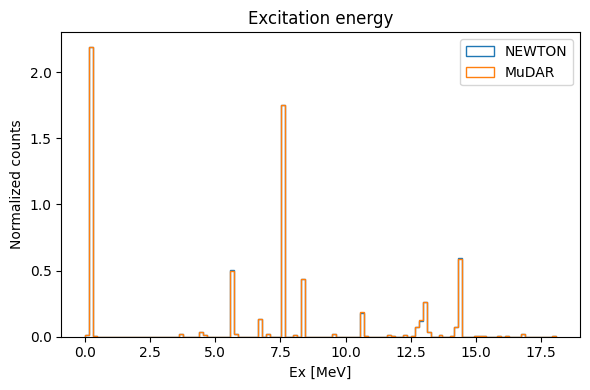

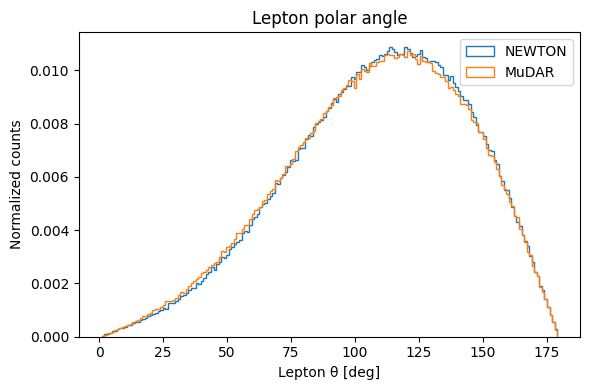

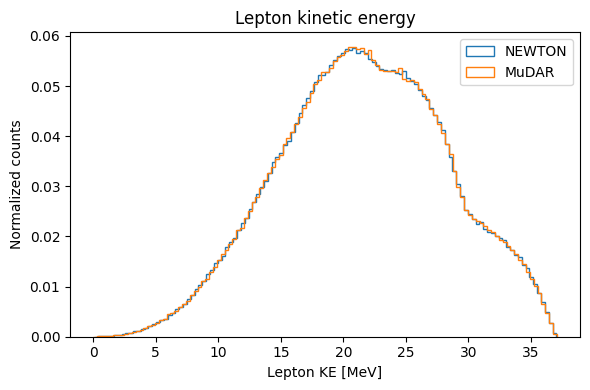

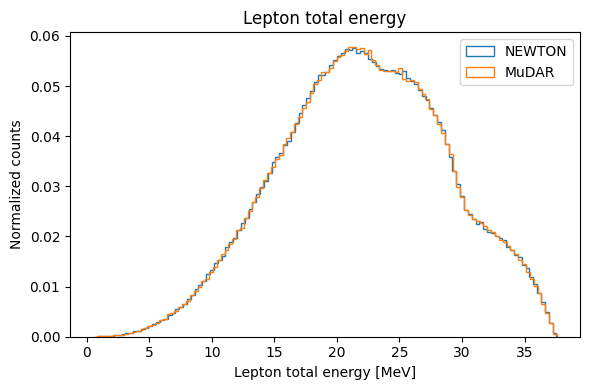

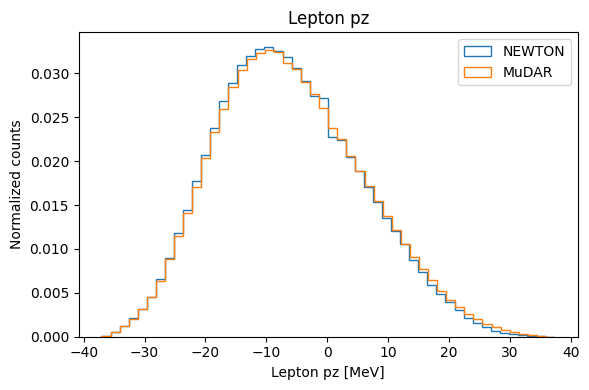

In [38]:

def overlay_hist_1d(xA, xB, bins=100, xlabel="", title="", range=None):
    plt.figure(figsize=(6,4))
    plt.hist(xA, bins=bins, range=range, histtype="step", density=True, label="NEWTON")
    plt.hist(xB, bins=bins, range=range, histtype="step", density=True, label="MuDAR")
    plt.xlabel(xlabel)
    plt.ylabel("Normalized counts")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# masks for lepton-only quantities
mA = dataA["has_lepton"]
mB = dataB["has_lepton"]

# ---------- Event-level ----------
overlay_hist_1d(
    dataA["Enu"], dataB["Enu"],
    bins=120, xlabel="Eν [MeV]", title="Neutrino energy"
)

overlay_hist_1d(
    dataA["Ex"], dataB["Ex"],
    bins=120, xlabel="Ex [MeV]", title="Excitation energy"
)

overlay_hist_1d(
    dataA["theta_deg"], dataB["theta_deg"],
    bins=179, xlabel="Lepton θ [deg]", title="Lepton polar angle"
)

# ---------- Lepton-only ----------
overlay_hist_1d(
    dataA["lep_ke"][mA], dataB["lep_ke"][mB],
    bins=120, xlabel="Lepton KE [MeV]", title="Lepton kinetic energy"
)

overlay_hist_1d(
    dataA["lep_totalE"][mA], dataB["lep_totalE"][mB],
    bins=120, xlabel="Lepton total energy [MeV]", title="Lepton total energy"
)

overlay_hist_1d(
    dataA["lep_pz"][mA], dataB["lep_pz"][mB],
    bins=50, xlabel="Lepton pz [MeV]", title="Lepton pz"
)

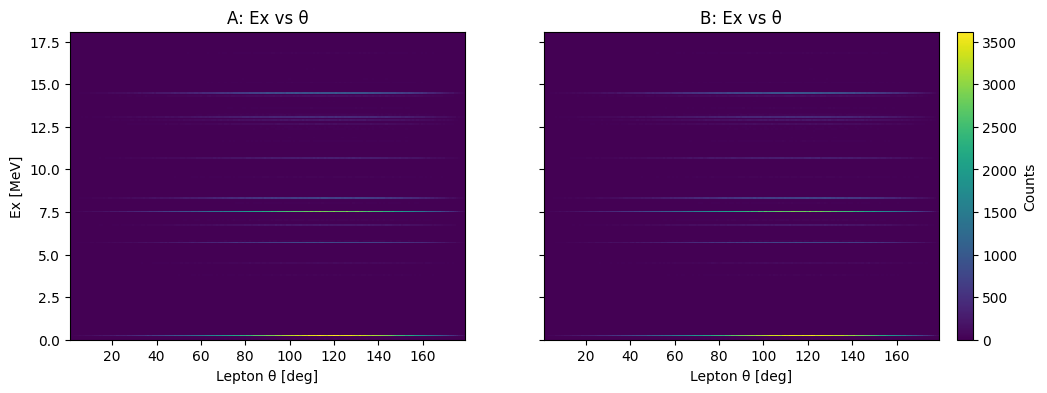

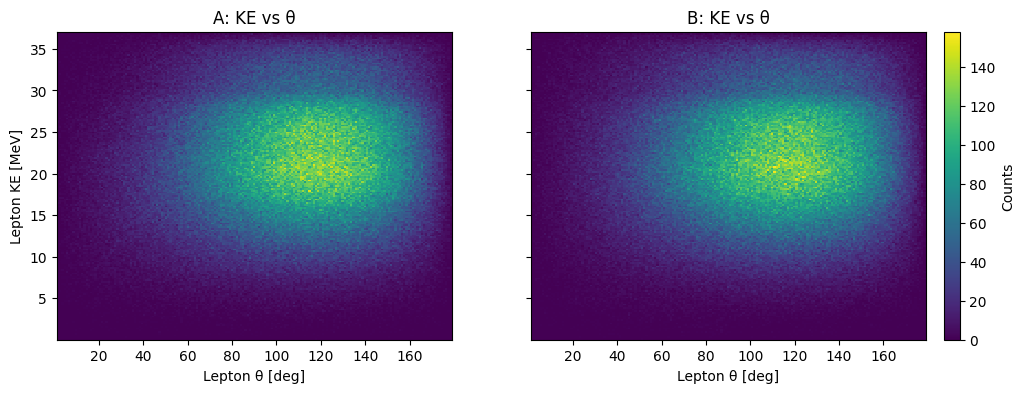

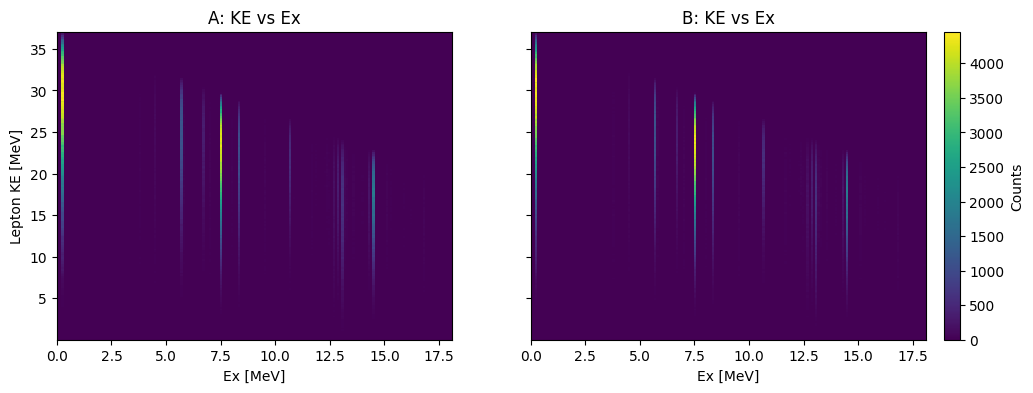

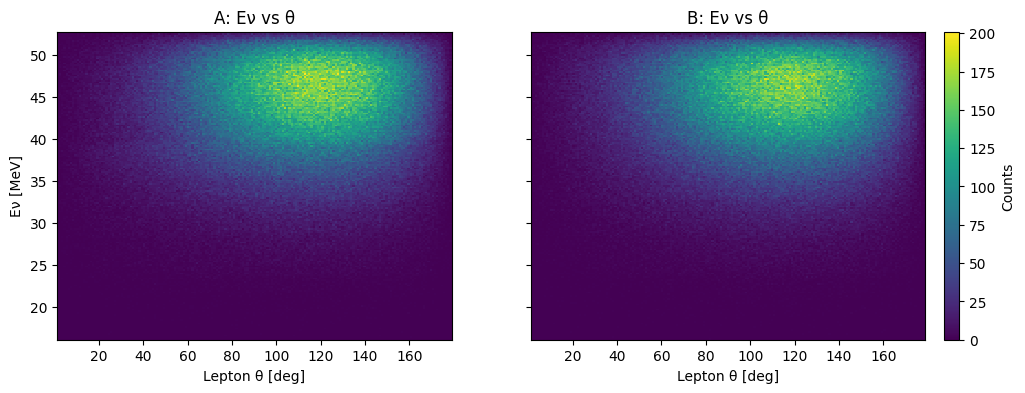

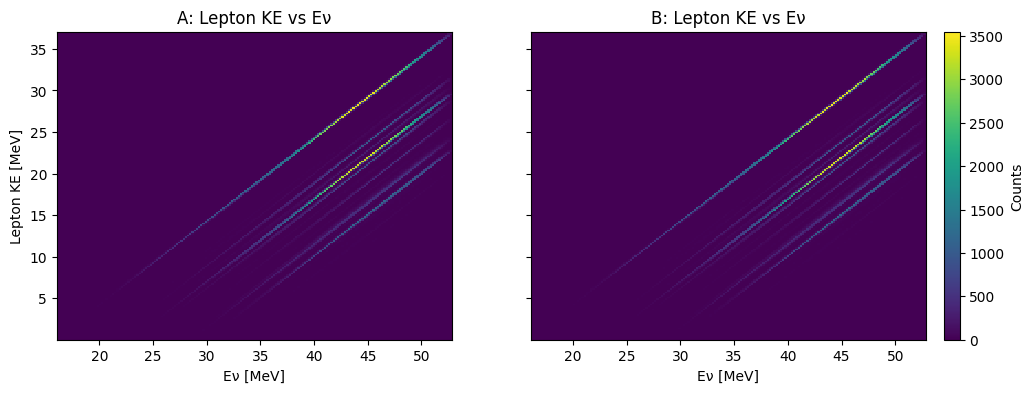

In [32]:


def hist2d_side_by_side(xA, yA, xB, yB,
                        bins=120,
                        xlabel="",
                        ylabel="",
                        titleA="NEWTON",
                        titleB="MuDAR",
                        range=None):

  # Compute shared limits
  if range is None:
    xmin = min(np.min(xA), np.min(xB))
    xmax = max(np.max(xA), np.max(xB))
    ymin = min(np.min(yA), np.min(yB))
    ymax = max(np.max(yA), np.max(yB))
    range = [[xmin, xmax], [ymin, ymax]]

  # Precompute shared vmax so color scale matches
  H_A, _, _ = np.histogram2d(xA, yA, bins=bins, range=range)
  H_B, _, _ = np.histogram2d(xB, yB, bins=bins, range=range)
  vmax = max(H_A.max(), H_B.max())

  fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

  h0 = axes[0].hist2d(xA, yA, bins=bins, range=range, vmin=0, vmax=vmax)
  axes[0].set_title(titleA)
  axes[0].set_xlabel(xlabel)
  axes[0].set_ylabel(ylabel)

  h1 = axes[1].hist2d(xB, yB, bins=bins, range=range, vmin=0, vmax=vmax)
  axes[1].set_title(titleB)
  axes[1].set_xlabel(xlabel)

  cbar = fig.colorbar(h1[3], ax=axes, location="right", pad=0.02, fraction=0.046)
  cbar.set_label("Counts")

  plt.show()



# -----------------------------
# Ex vs lepton angle (all events)
# -----------------------------
hist2d_side_by_side(
    dataA["theta_deg"], dataA["Ex"],
    dataB["theta_deg"], dataB["Ex"],
    bins=179,
    xlabel="Lepton θ [deg]",
    ylabel="Ex [MeV]",
    titleA="A: Ex vs θ",
    titleB="B: Ex vs θ"
)

# --------------------------------
# Lepton KE vs lepton angle
# (lepton-only events)
# --------------------------------
hist2d_side_by_side(
    dataA["theta_deg"][mA], dataA["lep_ke"][mA],
    dataB["theta_deg"][mB], dataB["lep_ke"][mB],
    bins=179,
    xlabel="Lepton θ [deg]",
    ylabel="Lepton KE [MeV]",
    titleA="A: KE vs θ",
    titleB="B: KE vs θ"
)

# -----------------------------
# Lepton KE vs Ex
# -----------------------------
hist2d_side_by_side(
    dataA["Ex"][mA], dataA["lep_ke"][mA],
    dataB["Ex"][mB], dataB["lep_ke"][mB],
    bins=179,
    xlabel="Ex [MeV]",
    ylabel="Lepton KE [MeV]",
    titleA="A: KE vs Ex",
    titleB="B: KE vs Ex"
)

# --------------------------------
# Enu vs lepton angle
# (all events: theta_deg is already per-event)
# --------------------------------
hist2d_side_by_side(
    dataA["theta_deg"], dataA["Enu"],
    dataB["theta_deg"], dataB["Enu"],
    bins=179,
    xlabel="Lepton θ [deg]",
    ylabel="Eν [MeV]",
    titleA="A: Eν vs θ",
    titleB="B: Eν vs θ"
)

# --------------------------------
# Enu vs lepton energy (KE)
# (lepton-only events)
# --------------------------------
hist2d_side_by_side(
    dataA["Enu"][mA], dataA["lep_ke"][mA],
    dataB["Enu"][mB], dataB["lep_ke"][mB],
    bins=179,
    xlabel="Eν [MeV]",
    ylabel="Lepton KE [MeV]",
    titleA="A: Lepton KE vs Eν",
    titleB="B: Lepton KE vs Eν"
)


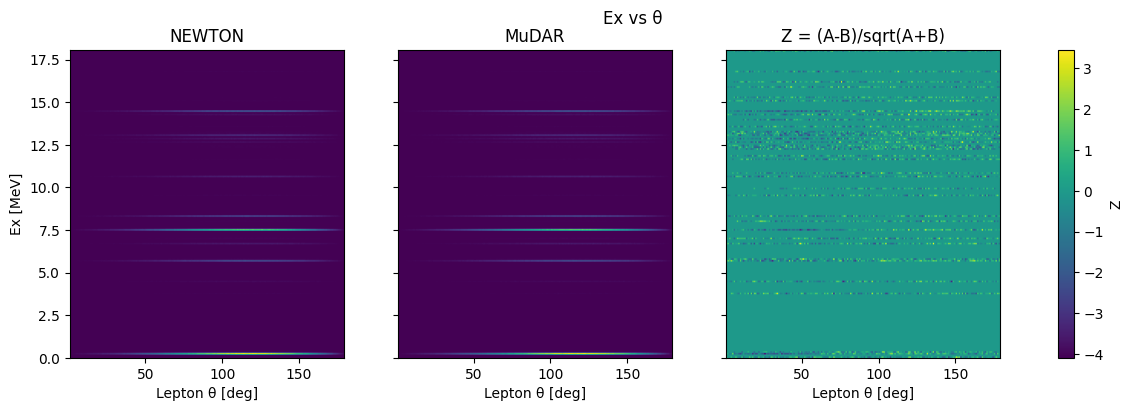

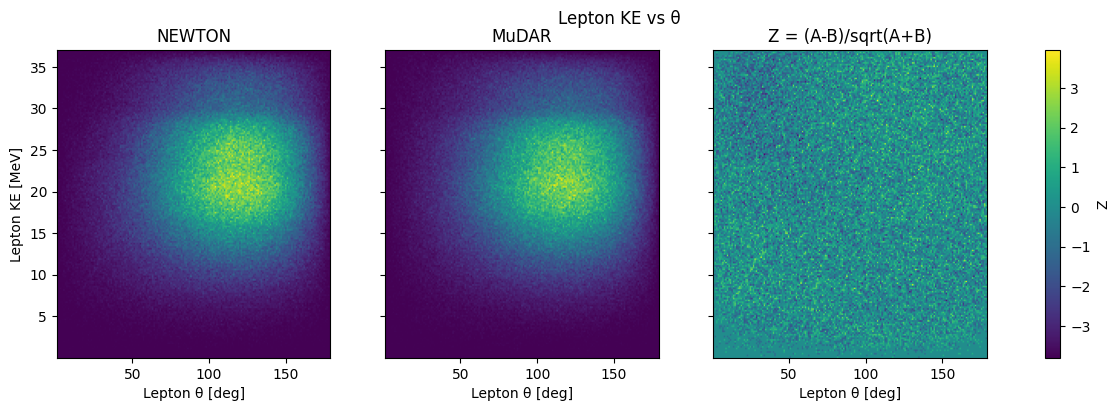

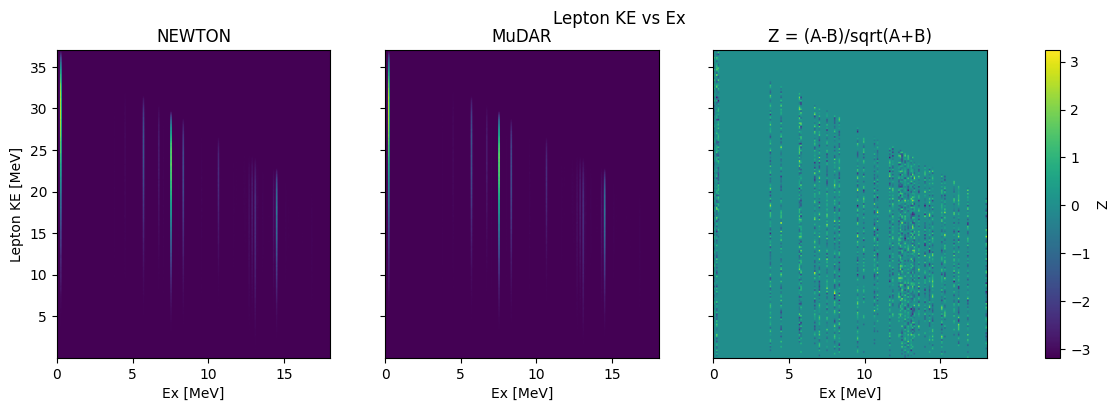

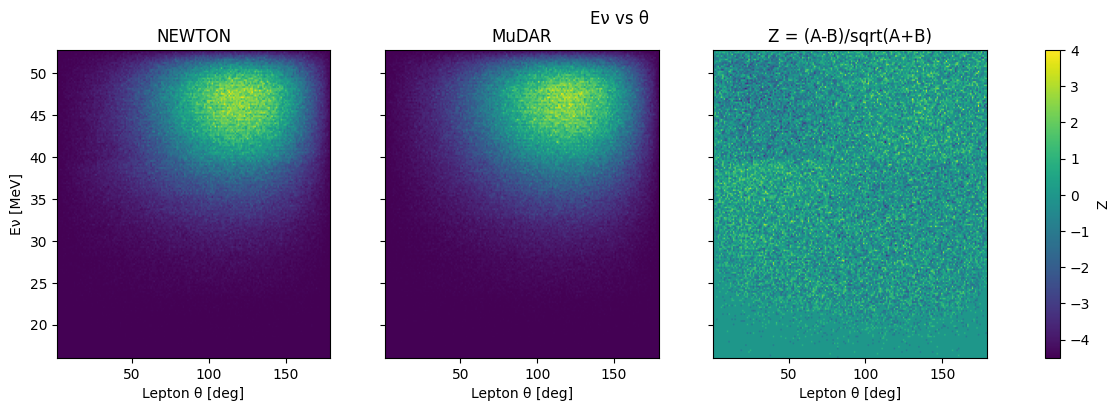

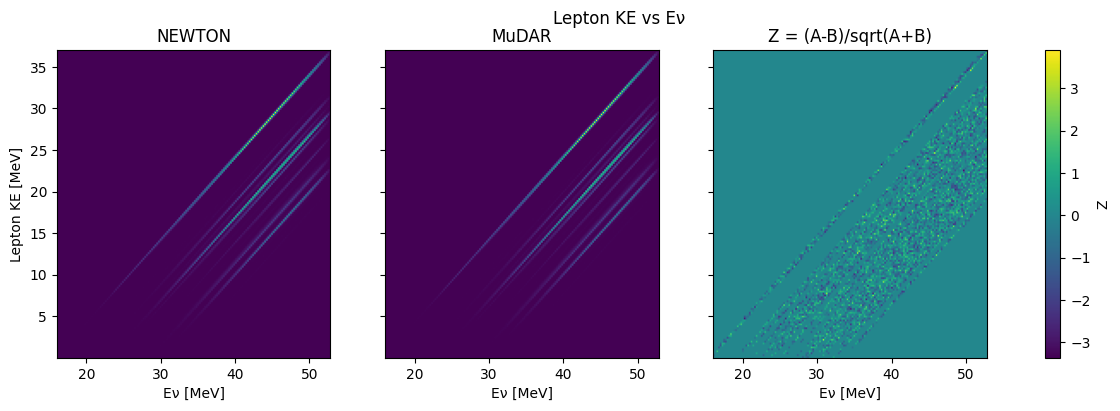

In [34]:
def diff_map(xA, yA, xB, yB,
             bins=120,
             xlabel="",
             ylabel="",
             title="",
             range=None):

  # Shared range
  if range is None:
    xmin = min(np.min(xA), np.min(xB))
    xmax = max(np.max(xA), np.max(xB))
    ymin = min(np.min(yA), np.min(yB))
    ymax = max(np.max(yA), np.max(yB))
    range = [[xmin, xmax], [ymin, ymax]]

  H_A, xedges, yedges = np.histogram2d(xA, yA, bins=bins, range=range)
  H_B, _, _           = np.histogram2d(xB, yB, bins=bins, range=range)

  # A-B and significance
  D = H_A - H_B
  Z = D / np.sqrt(H_A + H_B + 1e-12)

  fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

  im0 = axes[0].imshow(H_A.T, origin="lower", aspect="auto",
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  axes[0].set_title("NEWTON")
  axes[0].set_xlabel(xlabel)
  axes[0].set_ylabel(ylabel)

  im1 = axes[1].imshow(H_B.T, origin="lower", aspect="auto",
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  axes[1].set_title("MuDAR")
  axes[1].set_xlabel(xlabel)

  im2 = axes[2].imshow(Z.T, origin="lower", aspect="auto",
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  axes[2].set_title("Z = (A-B)/sqrt(A+B)")
  axes[2].set_xlabel(xlabel)

  fig.suptitle(title)
  fig.colorbar(im2, ax=axes, label="Z")
  plt.show()


# -----------------------------
# Ex vs theta (all events)
# -----------------------------
diff_map(
  dataA["theta_deg"], dataA["Ex"],
  dataB["theta_deg"], dataB["Ex"],
  bins=179,
  xlabel="Lepton θ [deg]",
  ylabel="Ex [MeV]",
  title="Ex vs θ"
)

# -----------------------------
# Lepton KE vs theta (lepton only)
# -----------------------------
diff_map(
  dataA["theta_deg"][mA], dataA["lep_ke"][mA],
  dataB["theta_deg"][mB], dataB["lep_ke"][mB],
  bins=179,
  xlabel="Lepton θ [deg]",
  ylabel="Lepton KE [MeV]",
  title="Lepton KE vs θ"
)

# -----------------------------
# Lepton KE vs Ex (lepton only)
# -----------------------------
diff_map(
  dataA["Ex"][mA], dataA["lep_ke"][mA],
  dataB["Ex"][mB], dataB["lep_ke"][mB],
  bins=179,
  xlabel="Ex [MeV]",
  ylabel="Lepton KE [MeV]",
  title="Lepton KE vs Ex"
)

# -----------------------------
# Enu vs theta (all events)
# -----------------------------
diff_map(
  dataA["theta_deg"], dataA["Enu"],
  dataB["theta_deg"], dataB["Enu"],
  bins=179,
  xlabel="Lepton θ [deg]",
  ylabel="Eν [MeV]",
  title="Eν vs θ"
)

# -----------------------------
# Enu vs lepton KE (lepton only)
# -----------------------------
diff_map(
  dataA["Enu"][mA], dataA["lep_ke"][mA],
  dataB["Enu"][mB], dataB["lep_ke"][mB],
  bins=160,
  xlabel="Eν [MeV]",
  ylabel="Lepton KE [MeV]",
  title="Lepton KE vs Eν"
)


{'name': 'A Enu', 'N': 1000000, 'mean': 43.37472915649414, 'std': 5.577835559844971, 'min': 16.31999969482422, 'max': 52.81999969482422}
{'name': 'B Enu', 'N': 1000000, 'mean': 43.37068557739258, 'std': 5.5831193923950195, 'min': 16.049999237060547, 'max': 52.810001373291016}
{'name': 'A Ex', 'N': 1000000, 'mean': 6.303656578063965, 'std': 4.951607704162598, 'min': 0.0, 'max': 18.079999923706055}
{'name': 'B Ex', 'N': 1000000, 'mean': 6.30237340927124, 'std': 4.95247745513916, 'min': 0.0, 'max': 18.079999923706055}
{'name': 'A theta', 'N': 1000000, 'mean': 108.60043334960938, 'std': 34.91645050048828, 'min': 1.0, 'max': 179.0}
{'name': 'B theta', 'N': 1000000, 'mean': 107.73450469970703, 'std': 35.363670349121094, 'min': 1.0, 'max': 179.0}
{'name': 'A lep KE', 'N': 1000000, 'mean': 21.558130127236, 'std': 6.614341231739905, 'min': 0.11239012330770493, 'max': 37.03548812866211}
{'name': 'B lep KE', 'N': 1000000, 'mean': 21.55665527680092, 'std': 6.610847315756571, 'min': 0.0005896074580

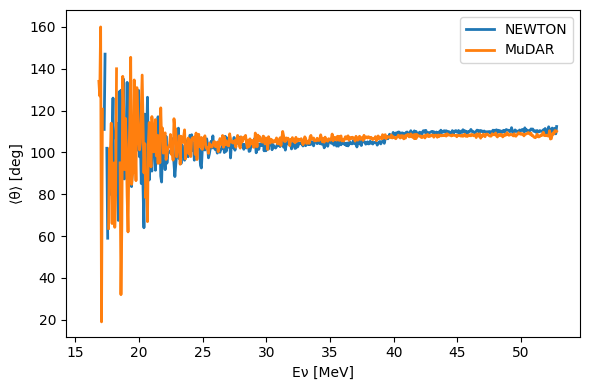

In [35]:
def summarize(name, x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    return {
        "name": name,
        "N": int(x.size),
        "mean": float(np.mean(x)) if x.size else np.nan,
        "std": float(np.std(x)) if x.size else np.nan,
        "min": float(np.min(x)) if x.size else np.nan,
        "max": float(np.max(x)) if x.size else np.nan,
    }

mA = dataA["has_lepton"]
mB = dataB["has_lepton"]

summaries = [
    summarize("A Enu", dataA["Enu"]),
    summarize("B Enu", dataB["Enu"]),
    summarize("A Ex", dataA["Ex"]),
    summarize("B Ex", dataB["Ex"]),
    summarize("A theta", dataA["theta_deg"]),
    summarize("B theta", dataB["theta_deg"]),
    summarize("A lep KE", dataA["lep_ke"][mA]),
    summarize("B lep KE", dataB["lep_ke"][mB]),
]

for s in summaries:
    print(s)

def mean_theta_vs_enu(theta, enu, enu_edges):
    idx = np.digitize(enu, enu_edges) - 1
    means = []
    centers = 0.5 * (enu_edges[:-1] + enu_edges[1:])
    for i in range(len(centers)):
        m = idx == i
        means.append(np.mean(theta[m]) if np.any(m) else np.nan)
    return centers, np.array(means)

enu_edges = np.linspace(
    min(dataA["Enu"].min(), dataB["Enu"].min()),
    max(dataA["Enu"].max(), dataB["Enu"].max()),
    531   # 530 bins
)

enu_c_A, mean_theta_A = mean_theta_vs_enu(
    dataA["theta_deg"], dataA["Enu"], enu_edges
)
enu_c_B, mean_theta_B = mean_theta_vs_enu(
    dataB["theta_deg"], dataB["Enu"], enu_edges
)

plt.figure(figsize=(6,4))
plt.plot(enu_c_A, mean_theta_A, label="NEWTON", lw=2)
plt.plot(enu_c_B, mean_theta_B, label="MuDAR", lw=2)
plt.xlabel("Eν [MeV]")
plt.ylabel("⟨θ⟩ [deg]")
plt.legend()
plt.tight_layout()
plt.show()